# Downstream analysis of clusters per cell

We look on per-cell basis at membranes vs non-membranes for each cell

In [1]:
import matplotlib.pyplot as plt
from locpix.preprocessing import datastruc
from locpix.visualise import vis_img
from locpix.img_processing import render
import os
import numpy as np
import json
import seaborn as sns
import pandas as pd
import polars as pl
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.neighbors import NearestNeighbors
import mplcursors
import networkx as nx
from skimage.graph import RAG
from scipy.spatial.distance import pdist

## Define functions

In [2]:
def convex_hull(array):
    """Convex hull function

    Args:
        array (numpy array) : Input array

    Returns:
        perimieter (float) : Perimeter of the 2D convex hull
        area (float) : Area of the convex hull
        np.max(neigh_dist) : Maximum length of the convex hull"""

    hull = ConvexHull(array)
    vertices = hull.vertices
    neigh = NearestNeighbors(n_neighbors=len(vertices))
    neigh.fit(array[vertices])
    neigh_dist, _ = neigh.kneighbors(array[vertices], return_distance=True)
    perimeter = hull.area
    area = hull.volume
    length = np.max(neigh_dist)
    # print("length via convex hull", length)
    return perimeter, area, length

def cluster_algo(df, eps, min_samples):
        arr = df[["x", "y"]].to_numpy()
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(arr)
    
        df = df.with_columns(
                pl.lit(clustering.labels_.astype("int32")).alias("clusterID")
        )
        
        # drop unclustered points
        df = df.filter(pl.col("clusterID") != -1)
    
        # Dropping all clusters with 2 or fewer locs - otherwise convex hull fails
        small_clusters = df.group_by("clusterID").len().filter(pl.col("len") < 3)
        df = df.filter(~pl.col("clusterID").is_in(small_clusters["clusterID"]))
    
        # remap the clusterIDs
        unique_clusters = list(df["clusterID"].unique())
        map = {value: i for i, value in enumerate(unique_clusters)}
        df = df.with_columns(pl.col("clusterID").replace(map).alias("clusterID"))

        #plt.close("all")
        #%matplotlib inline
        #plt.scatter(df["x"], df["y"], c=df["clusterID"], s=1)
        #plt.show()
        #input("stop")
    
        return df

def cluster(df, eps, min_samples, print_results=True):

    df = cluster_algo(df, eps, min_samples)

    # basic features (com cluster, locs per cluster, radius of gyration)
    cluster_df = df.group_by("clusterID").agg(
        [
            pl.len(),
            pl.col("x").mean().name.suffix("_mean"),
            pl.col("y").mean().name.suffix("_mean"),
        ]
    )

    locs_per_cluster = cluster_df.select(pl.col("len")).to_numpy().flatten()
    median_locs_per_cluster = cluster_df.select(pl.median("len")).to_numpy()[0][0]
    if print_results:
        print("Median locs per cluster", median_locs_per_cluster)


    df_split = df.partition_by("clusterID")
    cluster_id = df["clusterID"].unique().to_numpy()

    array_list = [
        df.select(pl.col(["x", "y"])).to_numpy() for df in df_split
    ]  # slow

    results = []

    for arr in array_list:
        results.append(convex_hull(arr))

    array = np.array(results)
    perimeters = array[:, 0]
    areas = array[:, 1]
    lengths = array[:, 2]

    cluster_df = pl.DataFrame(
        {
            "clusterID": cluster_id,
            "perimeter": perimeters,
            "area_convex_hull": areas,
            "length_convex_hull": lengths,
        }
    )

    cluster_length = cluster_df.select(pl.col("length_convex_hull")).to_numpy().flatten()
    median_cluster_length = cluster_df.select(pl.median("length_convex_hull")).to_numpy()[0][0]        
    median_perimeter = cluster_df.select(pl.median("perimeter")).to_numpy()[0][0]
    median_area = cluster_df.select(pl.median("area_convex_hull")).to_numpy()[0][0]

    if print_results:
        print("Median cluster area", median_area)
        print("Median perimeter", median_perimeter)
        print("Median cluster length", median_cluster_length)

    return median_locs_per_cluster, median_cluster_length, locs_per_cluster, cluster_length

def label_2_4_colours(labels: np.ndarray):
    """This takes in an array of labels
    e.g. [5,0,2,2,17,1,...]
    and returns a list where each label is now
    in range 0-3 such that no 2 integers next to
    each other are the same.
    This can be used for to plot so no 2 colours
    next to each other are the same

    Args:
        labels (np.ndarray): Array of ints
        each representing a unique label~

    Returns:
        Array of ints each representing a
        unique label (between 0 and 3) no
        2 of same label should be next to each other"""

    graph = RAG(labels)
    d = nx.coloring.greedy_color(graph)
    # dict empty and only one label
    if not d and np.min(labels) == np.max(labels):
        d = {np.min(labels): 0}
    return np.vectorize(d.get)(labels)


def rdf(array, density, max_distance, bin_size):
    
    n_clusters = len(array)
    distances = pdist(array, 'euclidean')
    
    hist, binedges = np.histogram(distances, bins=int(max_distance / bin_size), range=(0,max_distance))
    
    bincentres = (binedges[:(len(binedges) - 1)] + binedges[1:]) / 2
    paircorr = hist / n_clusters / (2 * np.pi * bincentres * bin_size) / density

    return paircorr, bincentres

def rdf_locs(df, max_distance, bin_size):
    
    arr = df[["x", "y"]].to_numpy()
    n_locs = len(arr)
    cell_area = ConvexHull(arr).volume
    density = n_locs/cell_area

    return rdf(arr, density, max_distance, bin_size)

def rdf_clusters(df, max_distance, bin_size):
    cluster_df = df.group_by("clusterID").agg(
        [
            pl.col("x").mean().name.suffix("_mean"),
            pl.col("y").mean().name.suffix("_mean"),]
    )
    arr = cluster_df[["x_mean", "y_mean"]].to_numpy()
    n_clusters = len(arr)
    loc_arr = df[["x", "y"]].to_numpy()
    cell_area = ConvexHull(loc_arr).volume
    density = n_clusters/cell_area

    return rdf(arr, density, max_distance, bin_size)

## Parameters for clustering & rdf

In [3]:
eps = 75
min_samples = 5
max_distance =  500
bin_size = 10

## Cell segmentation

### Parameters

Will be visualising one test item at a time iterating through until visualised all and picked out the cells.
We will be clustering/visualising only the EGFR channel

In [4]:
files = ["C15_EREG568_EGFR647_FOV5"] # C15_EREG647_EGFR568_FOV1", "C15_EREG568_EGFR647_FOV3", "C15_EREG568_EGFR647_FOV5", "C15_EREG647_EGFR568_FOV1", "C15_EREG647_EGFR568_FOV5", "C15_EREG647_EGFR568_FOV7", "C15_EREG647_EGFR568_FOV8", "C15_EREG647_EGFR568_FOV10"]
channels = ['egfr']
threshold = 0
interpolation = 'linear'
alphas = [1,.5,.2,.1]
alpha_seg = 0.7
# cmap_seg = ["k", "y"]
cmap_img = ['w']
figsize = [10,10]
four_colour = True
background_one_colour = False
legend=False
column_vis="pred_label"
vmin_img=0
vmax_img=6
sum_chans=True
save=False
save_loc=None
visualise_cells = True

### Cluster EGFR

file C15_EREG568_EGFR647_FOV5


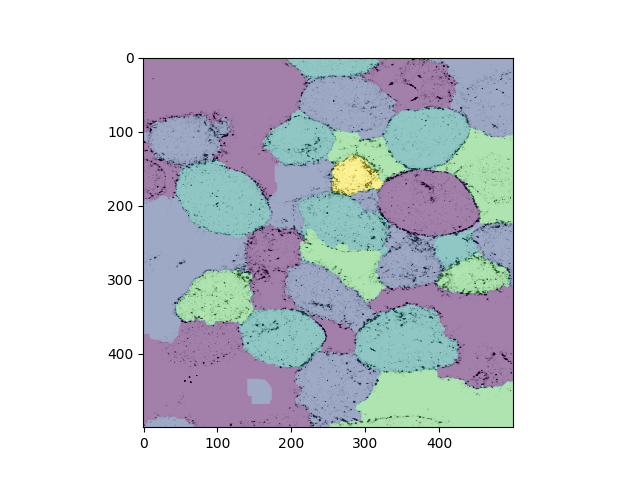

In [5]:
if visualise_cells:
    plt.close("all")
    %matplotlib widget

    for file in files:
        # folders
        input_img_folder = f"cell/seg_dataframes"
        input_seg_folder = f"cell/seg_img"
        input_memb_folder = f"membrane/seg_dataframes"

        # load memb and cell item
        cell_item = datastruc.item(None, None, None, None, None)
        cell_item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
        cell_item._coord_2_pixel()
        memb_item = datastruc.item(None, None, None, None, None)
        memb_item.load_from_parquet(os.path.join(input_memb_folder, file+'.parquet'))

        # render histogram & convert to img
        histo, channel_map, label_map = cell_item.render_histo(channels)
        img = np.transpose(histo, (0, 2, 1))

        # load segmentation
        segmentation = np.load(os.path.join(input_seg_folder, file+'.npy'))

        print('file', file)

        # Calculate cluster features per cell FOR ONLY EGFR
        user_channel = cell_item.label_2_chan("egfr")
        
        df_filtered = cell_item.df.filter(pl.col("channel") == user_channel)
        df_split = df_filtered.partition_by("pred_label")
        
        property_dict = {}
        for df in df_split:
            if len(df) > 2:
                results = cluster(df, eps, min_samples, print_results=False)
                property_dict[df["pred_label"].unique().item()] = results[:-2]
            else:
                property_dict[df["pred_label"].unique().item()] = None

        # Visualise cluster features per cell
        
        
        img_plot = np.sum(img, axis=0)
        fig, axes = plt.subplots(ncols=1)
        axes.imshow(img_plot, 
                cmap='Grays',
                vmin=0,
                vmax=10,
                origin="upper")
        
        segmentation_MOD = label_2_4_colours(segmentation)
        
        axes.imshow(segmentation_MOD,
                alpha=.5,
                origin="upper")
        cursor = mplcursors.cursor(hover=True)
        cursor.connect(
            "add", lambda sel: sel.annotation.set_text(f"median locs_per_cluster: {property_dict[segmentation[sel.index]][0]:.0f}\n\
        median cluster_length: {property_dict[segmentation[sel.index]][1]:.0f}\n\
        cell: {segmentation[sel.index]}"))
        plt.savefig("cell.eps", format="eps")
        plt.show()


## Plot clusters for one cell

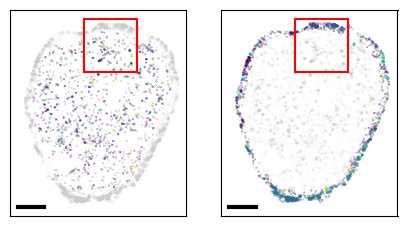

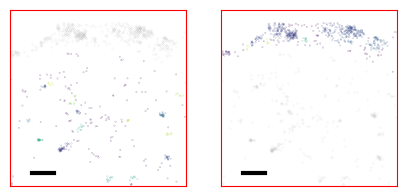

In [6]:
# pick file and cell
file = "C15_EREG568_EGFR647_FOV5"
cell = 8

# folders
input_img_folder = f"cell/seg_dataframes"
input_seg_folder = f"cell/seg_img"
input_memb_folder = f"membrane/seg_dataframes"

# load memb and cell item
cell_item = datastruc.item(None, None, None, None, None)
cell_item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
cell_item._coord_2_pixel()
memb_item = datastruc.item(None, None, None, None, None)
memb_item.load_from_parquet(os.path.join(input_memb_folder, file+'.parquet'))

# restrict to channel egfr
user_channel = cell_item.label_2_chan("egfr")
cell_df_filtered = cell_item.df.filter(pl.col("channel") == user_channel)
memb_df_filtered = memb_item.df.filter(pl.col("channel") == user_channel)

# reformat
cell_df_filtered = cell_df_filtered.rename({"pred_label": "cell_pred"})
memb_df_filtered = memb_df_filtered.rename({"pred_label": "memb_pred"})
joined_df = cell_df_filtered.join(memb_df_filtered, on = ["channel", "frame", "x", "y", "gt_label"]).drop(["x_pixel", "y_pixel"])

# pick out cell 
joined_df = joined_df.filter(pl.col("cell_pred") == cell)

# split memb and non-memb
non_memb_df = joined_df.filter(pl.col("memb_pred") == 0)
non_memb_cluster_df = cluster_algo(non_memb_df, eps, min_samples)
non_memb_df = non_memb_df.join(non_memb_cluster_df, on= ["channel", "frame", "x", "y", "gt_label", "cell_pred", "prob", "memb_pred"], how="left")
memb_df = joined_df.filter(pl.col("memb_pred") == 1) 
memb_cluster_df = cluster_algo(memb_df, eps, min_samples)
memb_df = memb_df.join(memb_cluster_df, on= ["channel", "frame", "x", "y", "gt_label", "cell_pred", "prob", "memb_pred"], how="left")

# replace nulls with 0
non_memb_df = non_memb_df.with_columns(pl.col("clusterID").fill_null(-1))
memb_df = memb_df.with_columns(pl.col("clusterID").fill_null(-1))

plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(5,5), sharex=True, sharey=True)
axs[0].tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
axs[0].set(aspect=1)
axs[0].scatter(non_memb_df[["x"]], non_memb_df[["y"]], c=non_memb_df[["clusterID"]], s=.01)
axs[0].scatter(memb_df[["x"]], memb_df[["y"]], c=".8", s=.01, alpha=1)
axs[0].plot([37000, 41000], [10800, 10800], '-', c='r')
axs[0].plot([37000, 37000], [10800, 14800], '-', c='r')
axs[0].plot([41000, 41000], [10800, 14800], '-', c='r')
axs[0].plot([37000, 41000], [14800, 14800], '-', c='r')
axs[0].plot([32000, 34000], [25000, 25000], '-', c='k', lw=3)
#axs[0].ticklabel_format(style="sci", scilimits=[0,0])
axs[1].set(aspect=1)
axs[1].scatter(memb_df[["x"]], memb_df[["y"]], c=memb_df[["clusterID"]], s=.01)
axs[1].scatter(non_memb_df[["x"]], non_memb_df[["y"]], c=".8", s=.01)
axs[1].tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
axs[1].plot([37000, 41000], [10800, 10800], '-', c='r')
axs[1].plot([37000, 37000], [10800, 14800], '-', c='r')
axs[1].plot([41000, 41000], [10800, 14800], '-', c='r')
axs[1].plot([37000, 41000], [14800, 14800], '-', c='r')
axs[1].plot([32000, 34000], [25000, 25000], '-', c='k', lw=3)
plt.gca().invert_yaxis()
plt.savefig("cluster_plot.eps", format="eps")
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(5,5), sharex=True, sharey=True)
axs[0].tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
axs[0].set(aspect=1)
axs[0].scatter(non_memb_df[["x"]], non_memb_df[["y"]], c=non_memb_df[["clusterID"]], s=.01)
axs[0].scatter(memb_df[["x"]], memb_df[["y"]], c=".8", s=.01, alpha=1)
axs[0].set_ylim(10800,14800)
axs[0].set_xlim(37000,41000)
axs[0].plot([37500, 38000], [14500, 14500], '-', c='k', lw=3)
axs[0].spines['top'].set_color('red')
axs[0].spines['right'].set_color('red')
axs[0].spines['bottom'].set_color('red')
axs[0].spines['left'].set_color('red')
#axs[0].ticklabel_format(style="sci", scilimits=[0,0])
axs[1].set(aspect=1)
axs[1].scatter(memb_df[["x"]], memb_df[["y"]], c=memb_df[["clusterID"]], s=.01)
axs[1].scatter(non_memb_df[["x"]], non_memb_df[["y"]], c=".8", s=.01)
axs[1].tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
axs[1].plot([37500, 38000], [14500, 14500], '-', c='k', lw=3)
axs[1].spines['top'].set_color('red')
axs[1].spines['right'].set_color('red')
axs[1].spines['bottom'].set_color('red')
axs[1].spines['left'].set_color('red')
plt.gca().invert_yaxis()
plt.savefig("cluster_plot_zoom.eps", format="eps")
plt.show()

## Membrane vs non membrane clustering per cell

Cluster the EGFR for each cell comparing membrane to non-membrane

### Identify cells we want to analyse - manually

In [7]:
picked_cells = {
    "C15_EREG568_EGFR647_FOV3": [1,3, 7, 4, 20, 18, 19, 10, 12, 14], 
    "C15_EREG568_EGFR647_FOV5": [1, 5, 8, 4, 9, 11, 3, 13], 
    "C15_EREG647_EGFR568_FOV1": [11, 8, 22, 6, 19], 
    "C15_EREG647_EGFR568_FOV5": [26, 8, 2, 13], 
    "C15_EREG647_EGFR568_FOV7": [8, 9, 16, 31, 7, 6, 1, 2, 19, 27, 15, 18, 22], 
    "C15_EREG647_EGFR568_FOV8": [3, 4, 7, 16, 24, 15, 13, 8, 9, 17], 
    "C15_EREG647_EGFR568_FOV10": [5, 3, 7, 17, 8, 9, 10, 11, 12, 16], 
}
files = ["C15_EREG568_EGFR647_FOV3", "C15_EREG568_EGFR647_FOV5", "C15_EREG647_EGFR568_FOV1", "C15_EREG647_EGFR568_FOV5", "C15_EREG647_EGFR568_FOV7", "C15_EREG647_EGFR568_FOV8", "C15_EREG647_EGFR568_FOV10"]

assert sorted(list(picked_cells.keys())) == sorted(files)

### Radial distribution function for EGFR clusters for these cells

Compare radial distribution functions for membrane vs non-membrane

In [8]:
plt.close("all")
%matplotlib inline

cell_memb_locs_per_cluster = []
cell_memb_cluster_length = []
cell_non_memb_locs_per_cluster = []
cell_non_memb_cluster_length = []
cell_memb_rdfs = []
cell_non_memb_rdfs = []

for file in files:
    # folders
    input_img_folder = f"cell/seg_dataframes"
    input_seg_folder = f"cell/seg_img"
    input_memb_folder = f"membrane/seg_dataframes"

    # load memb and cell item
    cell_item = datastruc.item(None, None, None, None, None)
    cell_item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
    cell_item._coord_2_pixel()
    memb_item = datastruc.item(None, None, None, None, None)
    memb_item.load_from_parquet(os.path.join(input_memb_folder, file+'.parquet'))

    # restrict to channel egfr
    user_channel = cell_item.label_2_chan("egfr")
    cell_df_filtered = cell_item.df.filter(pl.col("channel") == user_channel)
    memb_df_filtered = memb_item.df.filter(pl.col("channel") == user_channel)

    # reformat
    cell_df_filtered = cell_df_filtered.rename({"pred_label": "cell_pred"})
    memb_df_filtered = memb_df_filtered.rename({"pred_label": "memb_pred"})
    joined_df = cell_df_filtered.join(memb_df_filtered, on = ["channel", "frame", "x", "y", "gt_label"]).drop(["x_pixel", "y_pixel"])

    # pick out cells 
    joined_df = joined_df.filter(pl.col("cell_pred").is_in(picked_cells[file]))
    cell_dfs = joined_df.partition_by("cell_pred")

    for df in cell_dfs:
        memb_df = df.filter(pl.col("memb_pred") == 1)
        memb_results = cluster(memb_df, eps=eps, min_samples=min_samples, print_results=False)
        rdf_memb, bin_centres = rdf_clusters(cluster_algo(memb_df, eps, min_samples), max_distance, bin_size)
        cell_memb_rdfs.append(rdf_memb)
        
        non_memb_df = df.filter(pl.col("memb_pred") == 0)
        non_memb_results = cluster(non_memb_df, eps=eps, min_samples=min_samples, print_results=False)
        rdf_non_memb, bin_centres = rdf_clusters(cluster_algo(non_memb_df, eps, min_samples), max_distance, bin_size)
        cell_non_memb_rdfs.append(rdf_non_memb)

        # statistics
        locs_per_cluster_memb, cluster_length_memb = memb_results[-2:]
        locs_per_cluster_non_memb, cluster_length_non_memb = non_memb_results[-2:]

        cell_non_memb_locs_per_cluster.extend(locs_per_cluster_non_memb)
        cell_non_memb_cluster_length.extend(cluster_length_non_memb)
        cell_memb_locs_per_cluster.extend(locs_per_cluster_memb)
        cell_memb_cluster_length.extend(cluster_length_memb)

r_plot = np.tile(bin_centres,len(cell_memb_rdfs))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


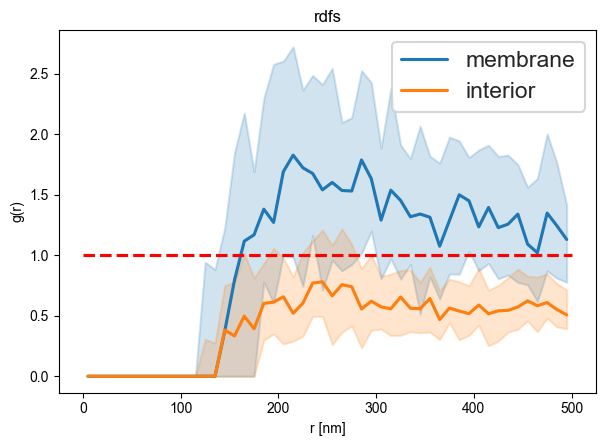

In [9]:
plt.title("rdfs")
sns.set_style("white")
sns.set_context("talk")
rdf_plot_memb = np.array(cell_memb_rdfs).flatten()
df_plot_memb = pd.DataFrame({"g(r)": rdf_plot_memb, "r [nm]": r_plot, "class": ["membrane"]*len(rdf_plot_memb)})
rdf_plot_non_memb = np.array(cell_non_memb_rdfs).flatten()
df_plot_non_memb = pd.DataFrame({"g(r)": rdf_plot_non_memb, "r [nm]": r_plot, "class": ["interior"]*len(rdf_plot_non_memb)})
df_plot = pd.concat([df_plot_memb, df_plot_non_memb])
g = sns.lineplot(data=df_plot, x="r [nm]", y="g(r)", errorbar=("pi",50), hue="class", estimator=np.median)
g.legend_.set_title(None)
plt.hlines(y=1.0, xmin=0.0, xmax=max_distance, color='r', linestyle='--')
plt.tight_layout()
plt.savefig(f"rdfs_cluster_{eps}_nm.eps", format="eps")
plt.show()

### Radial distribution function for EGFR locs for these cells

Compare radial distribution functions for membrane vs non-membrane

In [10]:
plt.close("all")
%matplotlib inline

cell_memb_rdfs = []
cell_non_memb_rdfs = []

for file in files:
    # folders
    input_img_folder = f"cell/seg_dataframes"
    input_seg_folder = f"cell/seg_img"
    input_memb_folder = f"membrane/seg_dataframes"

    # load memb and cell item
    cell_item = datastruc.item(None, None, None, None, None)
    cell_item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
    cell_item._coord_2_pixel()
    memb_item = datastruc.item(None, None, None, None, None)
    memb_item.load_from_parquet(os.path.join(input_memb_folder, file+'.parquet'))

    # restrict to channel egfr
    user_channel = cell_item.label_2_chan("egfr")
    cell_df_filtered = cell_item.df.filter(pl.col("channel") == user_channel)
    memb_df_filtered = memb_item.df.filter(pl.col("channel") == user_channel)

    # reformat
    cell_df_filtered = cell_df_filtered.rename({"pred_label": "cell_pred"})
    memb_df_filtered = memb_df_filtered.rename({"pred_label": "memb_pred"})
    joined_df = cell_df_filtered.join(memb_df_filtered, on = ["channel", "frame", "x", "y", "gt_label"]).drop(["x_pixel", "y_pixel"])

    # pick out cells 
    joined_df = joined_df.filter(pl.col("cell_pred").is_in(picked_cells[file]))
    cell_dfs = joined_df.partition_by("cell_pred")

    for df in cell_dfs:
        memb_df = df.filter(pl.col("memb_pred") == 1)
        rdf_memb, bin_centres = rdf_locs(memb_df, max_distance, bin_size)
        cell_memb_rdfs.append(rdf_memb)
        
        non_memb_df = df.filter(pl.col("memb_pred") == 0)
        rdf_non_memb, bin_centres = rdf_locs(non_memb_df, max_distance, bin_size)
        cell_non_memb_rdfs.append(rdf_non_memb)

r_plot = np.tile(bin_centres,len(cell_memb_rdfs))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


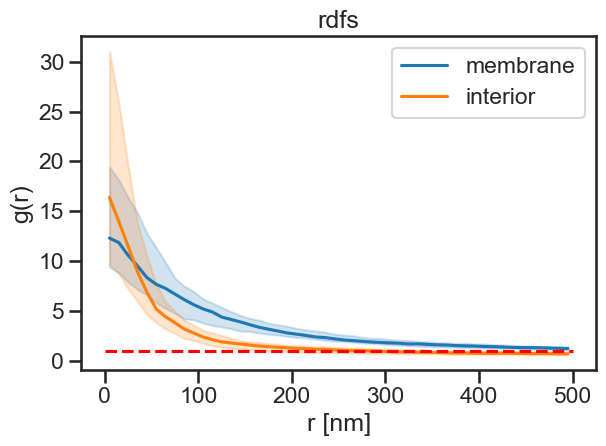

In [59]:
plt.title("rdfs")
sns.set_style("white")
sns.set_context("talk")
rdf_plot_memb = np.array(cell_memb_rdfs).flatten()
df_plot_memb = pd.DataFrame({"g(r)": rdf_plot_memb, "r [nm]": r_plot, "class": ["membrane"]*len(rdf_plot_memb)})
rdf_plot_non_memb = np.array(cell_non_memb_rdfs).flatten()
df_plot_non_memb = pd.DataFrame({"g(r)": rdf_plot_non_memb, "r [nm]": r_plot, "class": ["interior"]*len(rdf_plot_non_memb)})
df_plot = pd.concat([df_plot_memb, df_plot_non_memb])
g = sns.lineplot(data=df_plot, x="r [nm]", y="g(r)", errorbar=("pi",50), hue="class", estimator=np.median)
g.legend_.set_title(None)
plt.hlines(y=1.0, xmin=0.0, xmax=max_distance, color='r', linestyle='--')
plt.tight_layout()
plt.tick_params(left = True, labelleft=True, bottom = True, labelbottom=True)
plt.savefig("rdfs_locs.eps", format="eps")
plt.show()

## Get rdf for Alistair

In [12]:
memb_df_alistair = df_plot[df_plot["class"] == "membrane"]
memb_median = memb_df_alistair.groupby(['r [nm]'])[['g(r)']].apply(np.median).to_frame(name='g(r)').reset_index()
memb_mean = memb_df_alistair.groupby(['r [nm]'])[['g(r)']].apply(np.mean).to_frame(name='g(r)').reset_index()
interior_df_alistair = df_plot[df_plot["class"] == "interior"]
interior_median = interior_df_alistair.groupby(['r [nm]'])[['g(r)']].apply(np.median).to_frame(name='g(r)').reset_index()
interior_mean = interior_df_alistair.groupby(['r [nm]'])[['g(r)']].apply(np.mean).to_frame(name='g(r)').reset_index()
# write to csv
memb_median.to_csv("memb_median.csv", index=False)
memb_mean.to_csv("memb_mean.csv", index=False)
interior_median.to_csv("interior_median.csv", index=False)
interior_mean.to_csv("interior_mean.csv", index=False)

### Statistics

Localisations per cluster AND cluster area for membrane and non-membrane

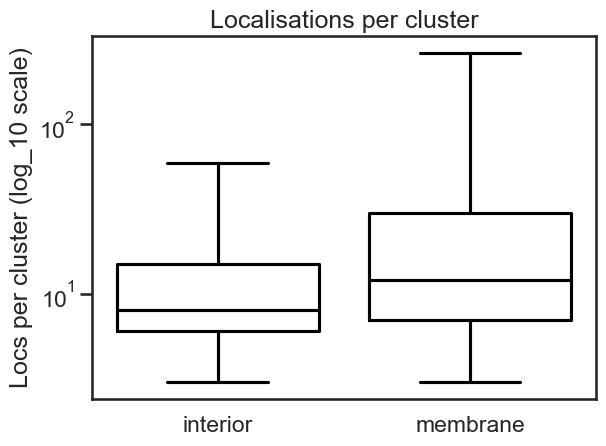

Non-membrane
------------
Median: 8.0
First quartile 6.0
Third quartile 15.0
Membrane
------------
Median: 12.0
First quartile 7.0
Third quartile 30.0


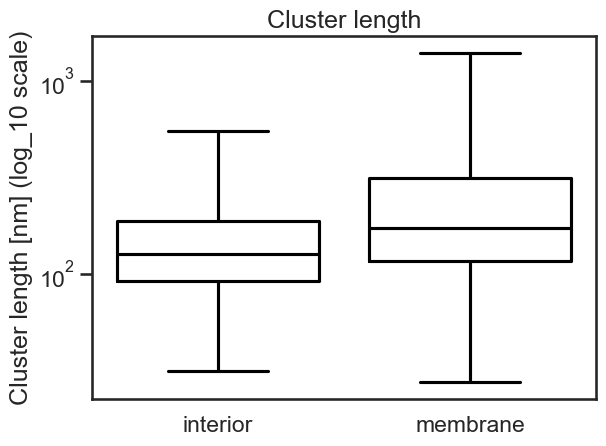

Non-membrane
------------
Median: 126.72780499449776
First quartile 92.34892301318709
Third quartile 188.62285473755747

Membrane
------------
Median: 173.88254252747592
First quartile 116.83892413095158
Third quartile 316.7481372547328


In [42]:
plt.close("all")
%matplotlib inline

data = {
    'locs_per_cluster': np.concatenate((cell_non_memb_locs_per_cluster ,cell_memb_locs_per_cluster)),
    'cluster_length [nm]': np.concatenate((cell_non_memb_cluster_length, cell_memb_cluster_length)),
    'class': ['interior'] * len(cell_non_memb_locs_per_cluster) + ['membrane'] * len(cell_memb_locs_per_cluster)
}

df = pd.DataFrame(data)
sns.set_style("white")
sns.set_context("talk")

# Create the boxplot
sns.boxplot(x='class', y='locs_per_cluster', data=df, log_scale=True, color='k', fill=False, showfliers=False)
plt.tick_params(left = True, labelleft=True, bottom = False, labelbottom=True)
plt.ylabel("Locs per cluster (log_10 scale)")
plt.xlabel(None)
plt.title('Localisations per cluster')
plt.tight_layout()
plt.savefig(f"locs_per_cluster_{eps}_nm.eps", format="eps")
plt.show()
median_locs_per_cluster_non_memb = np.median(cell_non_memb_locs_per_cluster)
q1_locs_per_cluster_non_memb = np.quantile(cell_non_memb_locs_per_cluster, .25)
q3_locs_per_cluster_non_memb = np.quantile(cell_non_memb_locs_per_cluster, .75)
print("Non-membrane")
print("------------")
print("Median:", median_locs_per_cluster_non_memb)
print("First quartile", q1_locs_per_cluster_non_memb)
print("Third quartile", q3_locs_per_cluster_non_memb)
median_locs_per_cluster_memb = np.median(cell_memb_locs_per_cluster)
q1_locs_per_cluster_memb = np.quantile(cell_memb_locs_per_cluster, .25)
q3_locs_per_cluster_memb = np.quantile(cell_memb_locs_per_cluster, .75)
print("Membrane")
print("------------")
print("Median:", median_locs_per_cluster_memb)
print("First quartile", q1_locs_per_cluster_memb)
print("Third quartile", q3_locs_per_cluster_memb)


sns.boxplot(x='class', y='cluster_length [nm]', data=df, log_scale=True, color='k', fill=False, showfliers=False)
plt.tick_params(left = True, labelleft=True, bottom = False, labelbottom=True)
plt.ylabel("Cluster length [nm] (log_10 scale)")
plt.xlabel(None)
plt.title('Cluster length')
plt.tight_layout()
plt.savefig(f"cluster_length_{eps}_nm.eps", format="eps")
plt.show()
median_cluster_length_non_memb = np.median(cell_non_memb_cluster_length)
q1_cluster_length_non_memb = np.quantile(cell_non_memb_cluster_length, .25)
q3_cluster_length_non_memb = np.quantile(cell_non_memb_cluster_length, .75)
print("Non-membrane")
print("------------")
print("Median:",median_cluster_length_non_memb)
print("First quartile", q1_cluster_length_non_memb)
print("Third quartile", q3_cluster_length_non_memb)
median_cluster_length_memb = np.median(cell_memb_cluster_length)
q1_cluster_length_memb = np.quantile(cell_memb_cluster_length, .25)
q3_cluster_length_memb = np.quantile(cell_memb_cluster_length, .75)
print("\nMembrane")
print("------------")
print("Median:", median_cluster_length_memb)
print("First quartile", q1_cluster_length_memb)
print("Third quartile", q3_cluster_length_memb)

## T-test

In [55]:
from scipy.stats import ttest_ind
interior_df = df[df["class"] == "interior"]
membrane_df = df[df["class"] == "membrane"]
print(interior_df.columns)
# t-test locs per cluster & cluster length
a = ttest_ind(interior_df["locs_per_cluster"], membrane_df["locs_per_cluster"])
b = ttest_ind(interior_df["cluster_length [nm]"], membrane_df["cluster_length [nm]"])

print(a)
print(b)

Index(['locs_per_cluster', 'cluster_length [nm]', 'class'], dtype='object')
TtestResult(statistic=-18.776375748330278, pvalue=1.008538038324352e-77, df=14322.0)
TtestResult(statistic=-27.757080720441913, pvalue=3.250668476550143e-165, df=14322.0)


## Addendum

Calculate data imbalance

In [14]:
all_files = os.listdir("cell/seg_dataframes")
test_files = ["C15_EREG568_EGFR647_FOV3", "C15_EREG568_EGFR647_FOV5", "C15_EREG647_EGFR568_FOV1", "C15_EREG647_EGFR568_FOV5", "C15_EREG647_EGFR568_FOV7", "C15_EREG647_EGFR568_FOV8", "C15_EREG647_EGFR568_FOV10"]
gt_labels = []
for file in all_files:
    if not file.rstrip(".parquet") in test_files:
        file_path = os.path.join("cell/seg_dataframes", file)
        cell_item = datastruc.item(None, None, None, None, None)
        cell_item.load_from_parquet(os.path.join(file_path))
        gt_labels.extend(cell_item.df["gt_label"].to_list())
gt_labels = np.array(gt_labels)

zeros = sum(gt_labels == 0)
ones = sum(gt_labels == 1)

print(zeros/ones)

2.01693097397929
